# Import libraries

In [1]:
import torch
import tensorboard

TORCH_VERSION = torch.__version__.split("+")[0]
CUDA_VERSION = torch.__version__.split("+")[1]
print(f"PyTorch: {TORCH_VERSION}; CUDA: {CUDA_VERSION}")

PyTorch: 1.10.2; CUDA: cu113


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [3]:
import os, random, json
import cv2

from matplotlib import pyplot as plt

from detectron2 import model_zoo

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor

from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.detection_utils as utils

In [4]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

In [5]:
from lib.datasets.DataPipeline import Pipeline
from lib.datasets.TensorDataset import TensorDataset

In [6]:
DATA_PATH = os.environ['DATA_PATH']
DATASET_PATH = os.path.abspath(os.path.join(DATA_PATH, 'detection_datasets/usa_parking'))
TILES_PATH = os.path.abspath(os.path.join(DATA_PATH, 'tiles'))
MODELS_PATH = os.path.abspath(os.path.join(os.getcwd(), '../models/'))

print(f"Current path : {os.getcwd()}")
print(f"Data path    : {DATA_PATH}")
print(f"Tiles path   : {TILES_PATH}")
print(f"Dataset path : {DATASET_PATH}")
print(f"Models path  : {MODELS_PATH}")

Current path : /srv/data/shared/sjindal/Parking_maps_Denso/notebooks
Data path    : /srv/data/shared/dev/data/
Tiles path   : /srv/data/shared/dev/data/tiles
Dataset path : /srv/data/shared/dev/data/detection_datasets/usa_parking
Models path  : /srv/data/shared/sjindal/Parking_maps_Denso/models


In [7]:
from torchvision.transforms import ToTensor
import torchvision
import numpy as np
from torch.optim import Adam
from torch.autograd import Variable

In [8]:
import pandas as pd
import numpy as np
from detectron2.data.detection_utils import read_image

import cv2

from lib.gdf_from_csv import gdf_from_csv
import math
import shutil

# Load data

need to do some changes for japan data

In [9]:
def square_image(image):
    _height, _width = image.shape[:2]
    if _height > _width:
        image = np.rot90(image)
        _height, _width = _width, _height
    shape = [_width, _width, *image.shape[2:]]
    result = np.zeros(shape)    
    idx = math.ceil((_width-_height)/2)
    result[idx:idx+_height] = image
    result = result.astype(np.uint8)
    return result

def read_data(pipeline):
    # Init dataset
    X = []
    y = []
    
    parking_path = os.path.join(DATA_PATH, "parking.csv")
    parking = pipeline.read_parking(parking_path)
    
    # Only USA data
    mask = pd.DataFrame([
        parking['country'].isin({'USA'}),
    ]).all()
    
    # Iterate over feature records
    for feature_id in parking.index[mask]:
        # Get 'line_color' label
        label = parking.loc[feature_id, 'line_color']
        # if None/Other label then do nothing 
        if label in {'None', 'Other'}:
            continue
        
        try:
            # Read space image RGB
            image_rgb_path = os.path.abspath(os.path.join(
                DATA_PATH, 
                f"recognition/features/{feature_id}/image_rgb.png",
            ))
            image_rgb = utils.read_image(image_rgb_path)
            
            # Read pred_mask image
            pred_mask_path = os.path.abspath(os.path.join(
                DATA_PATH, 
                f"recognition/features/{feature_id}/pred_mask.png",
            ))
            pred_mask = utils.read_image(pred_mask_path)
            
            body_image = cv2.bitwise_and(image_rgb, image_rgb, mask=pred_mask)    
        except:
            continue
            
        image = cv2.resize(square_image(body_image), (64, 64), interpolation=cv2.INTER_AREA)
            
        # Save feature to dataset
        X.append(image)
        y.append(label)
        
        # Augment if rare feature
        if label in {'Blue','White'}:
            # rotating 90 degree across all 3 axis
            for i in range(3):
                X.append(np.rot90(image.copy(), k=i+1))
                y.append(label)
            
            
    # Extract classes
    classes = np.unique(y).tolist()
    y = np.array([classes.index(i) for i in y])                
    return np.array(X), np.array(y), np.array(classes)



In [10]:
new_pipeline = Pipeline()

X, y, class_names = read_data(new_pipeline)

print('number of samples: ', X.shape[0])
print('\nimage shape:\n', X[0].shape, sep='')
print('\nlabels:\n', pd.Series(y).map(class_names.take).value_counts(), sep='')

X_train, y_train, X_test, y_test, X_val, y_val = new_pipeline.createTrainTestVal(X, y, makeVal=True)

batch_size = 100
learning_rate = 0.001

train_data = TensorDataset(X_train, y_train, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_data = TensorDataset(X_test, y_test, transform=ToTensor())
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valid_data = TensorDataset(X_val, y_val, transform=ToTensor())
valloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

number of samples:  33941

image shape:
(64, 64, 3)

labels:
Yellow    16673
White     15128
Blue       2140
dtype: int64


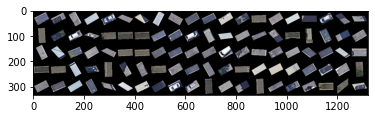

In [11]:
# functions to show an image
def show_batch_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
show_batch_grid(torchvision.utils.make_grid(images, nrow=20))

# Train model

In [12]:
import torch.nn as nn
from lib.recognition.line_color_clf import LineColorClassifier

line_color_clf = LineColorClassifier(class_names=class_names)    

In [13]:
print(line_color_clf._device)

cuda


In [14]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data,nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [15]:
import math

count = [(y==c).sum() for c in range(len(class_names))]
weights = [1/math.sqrt(i) for i in count]

weight_tensor = torch.Tensor(weights)

# Instantiate a neural network model 
line_color_clf._model.apply(initialize_weights)

# Loss function
weight_tensor = weight_tensor.to(line_color_clf._device)
loss_fn = nn.CrossEntropyLoss(weight = weight_tensor) 
optimizer = Adam(line_color_clf._model.parameters(), lr = 5e-5, weight_decay = 1e-5) # learning rate could be changed
line_color_clf._model.to(line_color_clf._device)

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [16]:
def saveModel(model,PATH):
    torch.save(model.state_dict(),PATH)
    return

In [17]:
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model,test_loader,device):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * float(accuracy) / float(total))
    return(accuracy)


def train(model,num_epochs,train_loader,test_loader,device,PATH):
    
    best_accuracy = 0.0
    model_path = os.path.abspath(os.path.join(PATH,'line_color_train.pth'))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        train_accuracy = testAccuracy(model, train_loader, device) 
        test_accuracy = testAccuracy(model , test_loader , device)
        
        #if (epoch+1)%5==0:   
        print(f'epoch : {(epoch+1):03d}/{num_epochs:03d}, loss: {loss.data.item():.5f}','train_acc: %f %%' % (train_accuracy),'val_acc: %f %%' % (test_accuracy))
        
        # we want to save the model if the accuracy is the best
        if test_accuracy > best_accuracy:
            if(os.path.isdir(PATH)):
                saveModel(model,model_path)
            else:
                os.mkdir(PATH)
                saveModel(model,model_path)
            best_accuracy = test_accuracy
            
    return

best_model_path = os.path.abspath(os.path.join(os.getcwd(),"../models/temp_training"))
train(line_color_clf._model, 50, trainloader, valloader, line_color_clf._device,best_model_path)
line_color_clf._model.load_state_dict(torch.load(os.path.abspath(os.path.join(best_model_path,'line_color_train.pth'))))
shutil.rmtree(best_model_path)
print('Finished Training')

epoch : 001/050, loss: 0.52019 train_acc: 77.118917 % val_acc: 76.247468 %
epoch : 002/050, loss: 0.42066 train_acc: 87.007965 % val_acc: 85.987848 %
epoch : 003/050, loss: 0.25872 train_acc: 88.656139 % val_acc: 87.258332 %
epoch : 004/050, loss: 0.24790 train_acc: 86.326596 % val_acc: 83.851961 %
epoch : 005/050, loss: 0.33631 train_acc: 89.710418 % val_acc: 88.234211 %
epoch : 006/050, loss: 0.22007 train_acc: 92.560195 % val_acc: 90.406923 %
epoch : 007/050, loss: 0.32515 train_acc: 92.725933 % val_acc: 89.394218 %
epoch : 008/050, loss: 0.37196 train_acc: 93.600663 % val_acc: 90.333272 %
epoch : 009/050, loss: 0.21567 train_acc: 93.306017 % val_acc: 90.149144 %
epoch : 010/050, loss: 0.17424 train_acc: 91.961696 % val_acc: 88.050083 %
epoch : 011/050, loss: 0.31968 train_acc: 93.701947 % val_acc: 88.197385 %
epoch : 012/050, loss: 0.02369 train_acc: 96.929239 % val_acc: 91.198674 %
epoch : 013/050, loss: 0.24873 train_acc: 95.888771 % val_acc: 90.112318 %
epoch : 014/050, loss: 0.

# Evaluate

In [18]:
test_accuracy = testAccuracy(line_color_clf._model,testloader,line_color_clf._device)
print("Test accuracy is :", test_accuracy)

Test accuracy is : 93.22433348063043


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score

In [20]:
line_color_clf._model.eval()

correct = 0

test = []
pred = []

for images, labels in testloader:
    images = Variable(images.float()).to(line_color_clf._device)
    outputs = line_color_clf._model(images)
    _, predicted = torch.max(outputs.data, 1)
    # correct += (predicted == labels).sum()
    test.extend(labels)
    pred.extend(predicted.cpu())
    
test = np.array(test)
pred = np.array(pred)

accuracy = (test==pred).sum() / test.shape[0] * 100
print('Test Accuracy of the model on test images: %.4f %%' % (accuracy))

Test Accuracy of the model on test images: 93.2243 %


<AxesSubplot:>

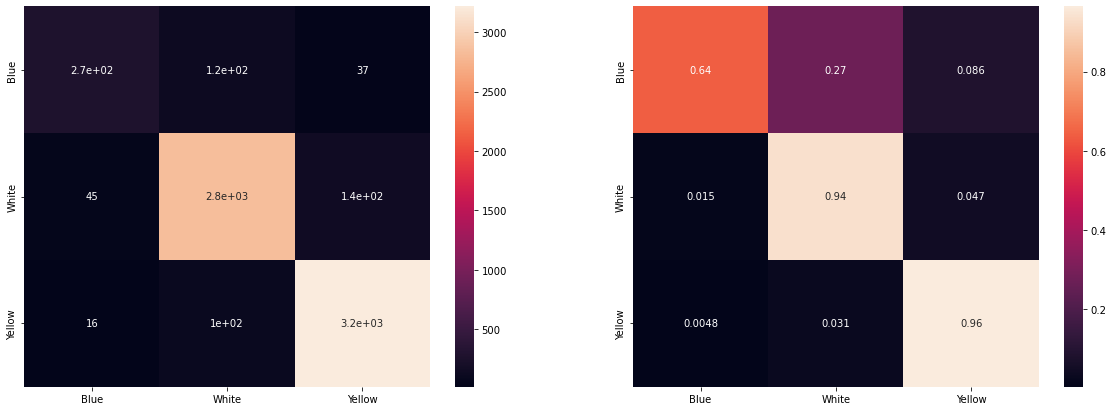

In [21]:
import seaborn as sn
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

matrix_avg = confusion_matrix(test, pred)
sn.heatmap(pd.DataFrame(matrix_avg, index=class_names, columns=class_names), ax=axes[0], annot=True)

matrix_pct = (matrix_avg.T / matrix_avg.sum(axis=1)).T
sn.heatmap(pd.DataFrame(matrix_pct, index=class_names, columns=class_names), ax=axes[1], annot=True)

In [22]:
pr = pd.DataFrame([
    precision_score(test, pred, average=None),
    recall_score(test, pred, average=None),
    f1_score(test, pred, average = None),
], columns=class_names, index=['precision', 'recall','f1']).round(2)

pr

,Blue,White,Yellow
precision,0.82,0.93,0.95
recall,0.64,0.94,0.96
f1,0.72,0.93,0.96


In [23]:
metrics = {
    "accuracy": accuracy_score(test, pred),
    "pr": pr.to_dict(),
    "confusion": pd.DataFrame(matrix_avg, index=class_names, columns=class_names).T.to_dict(),
}

line_color_clf.metrics = metrics

Please scecify your name:  Sahil Jindal


# Save model

In [24]:
PATH = "../models/recognition/line_color"
line_color_clf.save(PATH)

Folder already exists. Rewrite model at "../models/recognition/line_color"? (Y/n): y


Rewriting model...
Done!


In [25]:
print(PATH)
!ls $PATH

../models/recognition/line_color
class_names.json  metrics.json	model.pth
